# Capítulo X - Reward Shaping e Curriculum Learning


Vamos praticar essas duas técnicas no ambiente **"MountainCar-v0"** do gym.

Você pode rodar este notebook no Colab ou localmente. Para abrir diretamente no Colab, basta clicar no botão abaixo.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/capExtra/capX-other-techniques.ipynb) 

Para rodar localmente, primeiro, baixe todo o repositório do github: https://github.com/pablo-sampaio/rl_facil.

## 1. Configurações Iniciais

### Cria Diretório para Experimentos

In [1]:
!mkdir results

J� existe uma subpasta ou um arquivo results.


### Configurações Dependentes do Sistema

Rode a célula abaixo, mesmo sem estar no Colab.

In [3]:
import sys
from IPython.display import clear_output

if 'google.colab' in sys.modules:
    !pip install gym
    !pip install gym[box2d]
    !pip install optuna

    # para salvar videos
    !apt-get install -y xvfb x11-utils
    !pip install pyvirtualdisplay==0.2.*
    !apt-get install ffmpeg

    from pyvirtualdisplay import Display
    global display
    display = Display(visible=False, size=(1400, 900))
    _ = display.start()

    !git clone https://github.com/pablo-sampaio/rl_facil
    clear_output()

    !mv /content/rl_facil/cap04/* /content/
    !mv /content/rl_facil/cap05/* /content/
    !mv /content/rl_facil/cap06/* /content/

else:
    # atenção: para Windows apenas! 
    # se estiver no Linux, troque por "copy" por "cp" e mude a barra
    !copy ..\cap04\util_*.py .


..\cap04\util_experiments.py
..\cap04\util_plot.py
        2 arquivo(s) copiado(s).


### Configurações para Exibir Video

In [4]:
# ideias adaptadas de : https://www.anyscale.com/blog/an-introduction-to-reinforcement-learning-with-openai-gym-rllib-and-google
from base64 import b64encode
from IPython.display import HTML
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  html_code = f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'
  return HTML(html_code)

### Imports Principais

Import algoritmos, ambientes e outros módulos.

In [5]:
import gym
import numpy as np
import optuna

from util_experiments import repeated_exec
from util_plot import plot_result, plot_multiple_results

from models_torch import test_policy
#from crossentropy_method_v1 import run_crossentropy_method1, PolicyModelCrossentropy
from crossentropy_method_v2 import run_crossentropy_method2, PolicyModelCrossentropy

## 2. Modelagem de Recomepensas (Reward Shaping)

Na **modelagem de recompensas**, nós alteramos o modelo de recompensa do ambiente original para dar recompensas mais *informativa*.

Primeiro, criamos um wrapper do ambiente, em que damos recompensas adicionais a cada novo avanço conseguido pelo algoritmo na direção `x`.

Veja os detalhes do estado do MountainCar em https://www.gymlibrary.ml/environments/classic_control/mountain_car/ .

Ideia:
- Calcular o deslocamento `delta` em relação ao `x` inicial (pode ser para a esquerda ou direita)
- Toda vez que o agente ultrapassa o `delta` máximo obtido no episódio, ele recebe uma recompensa extra.
- Se atingir o alvo, recebe uma recompensa alta
- Atenção: pode estar violando a especificação de MDP

In [29]:
class FrequentRewardsMC(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def reset(self):
        obs = self.env.reset()
        self.dist = 0
        self.max_x = obs[0]
        self.min_x = obs[0]
        return obs
    
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        #delta = abs(obs[0] - self.initial_pos) # quão distante está da posição inicial
        if obs[0] > self.max_x:
            reward = self.max_x - obs[0]
            self.max_x = obs[0]
        if obs[0] < self.min_x:
            reward = self.min_x - obs[0]
            self.min_x = obs[0]
        if obs[0] >= 0.6:
            reward = 100.0
        return obs, reward, done, info


In [30]:
rmax = 50.0
ENV = gym.make("MountainCar-v0")
ENV = FrequentRewardsMC(ENV)

EPISODES   = 4000    # total de episódios
BATCH_SIZE = 50      # quantidade de episódios executados por época de treinamento
PROPORTION = 0.1     # percentual dos episódios (do batch) que serão selecionados

policy1 = PolicyModelCrossentropy(ENV.observation_space.shape[0], [512], ENV.action_space.n, lr=0.005)
returns, policy1 = run_crossentropy_method2(ENV, EPISODES, BATCH_SIZE, PROPORTION, initial_policy=policy1)
clear_output()

print("Últimos episódios do treinamento: media =", np.mean(returns[-20:]), ", desvio padrao =", np.std(returns[-20:]))


Últimos episódios do treinamento: media = -137.49604254737497 , desvio padrao = 11.569130717039483


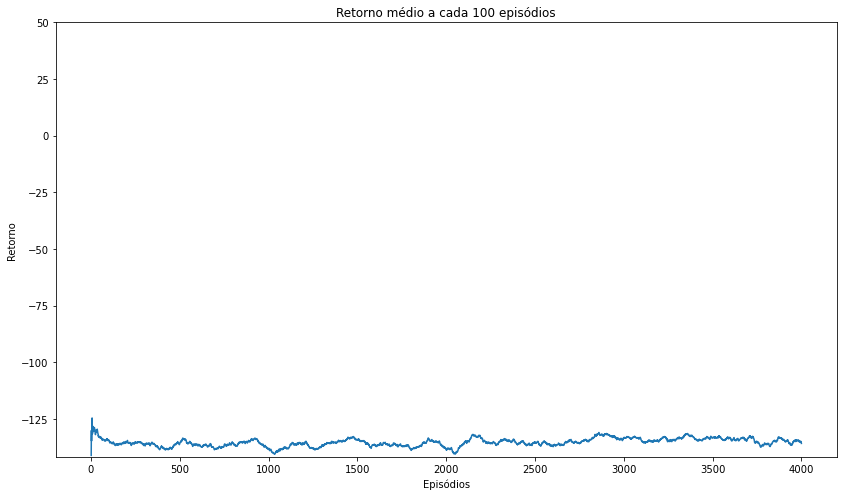

In [19]:
# Exibe um gráfico episódios x retornos (não descontados)
plot_result(returns, rmax)

In [15]:
# Faz alguns testes com o modelo de forma DETERMINÍSTICA e salva o vídeo em arquivo
video = VideoRecorder(ENV, "politica-treinada.mp4")
test_policy(ENV, policy1, True, 5, render=True, videorec=video)

EPISODE 1
- steps: 200
- return: -200.0
EPISODE 2
- steps: 200
- return: -200.0
EPISODE 3
- steps: 200
- return: -200.0
EPISODE 4
- steps: 200
- return: -200.0
EPISODE 5
- steps: 200
- return: -200.0
RESULTADO FINAL: média (por episódio): -200.0, episódios: 5, total de passos: 1000


(-200.0, [-200.0, -200.0, -200.0, -200.0, -200.0])

In [16]:
ENV.close()

In [ ]:
render_mp4("politica-treinada.mp4")

## 3. Aprendizagem por Currículo (Curriculum Learning)


Na *aprendizagem por currículo* aplicada em RL:
- o agente é treinado sequencialmente em *vários* ambientes (parecidos)
- os ambientes têm níveis crescentes de dificuldade
- ele deve aprender bem um deles antes de passar para o próximo

Abaixo, criamos um wrapper que permite instanciar **versões simplificadas do MountainCar**.
- a nova versão é parametrizada por um valor `goal_x`
- basta o agente ultrapassar essa posição com velocidade positiva para terminar o episódio
- a recompensa final é a velocidade (quanto mais rápido ele passar, melhor)
- se `goal_x > 0.6`, ele funciona idêntico ao ambiente original

In [26]:
class SimplifiedMC(gym.Wrapper):
    def __init__(self, env, goal_x):
        super().__init__(env)
        self.goal_x = goal_x

    def reset(self):
        obs = self.env.reset()
        self.max_x = self.min_x = obs[0]
        return obs
    
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        if obs[0] > self.max_x:
            reward = self.max_x - obs[0]
            self.max_x = obs[0]
        if obs[0] < self.min_x:
            reward = self.min_x - obs[0]
            self.min_x = obs[0]
        if obs[0] >= self.goal_x and obs[1] > 0:
            reward = 10.0
            done = True
        return obs, reward, done, info

Para treinar, vamos usar uma rede com DUAS camadas intermediárias: 128 e 256.

E vamos treinar em diferentes instâncais do ambiente acima, com valores de `goal_x` crescentes.

TREINANDO COM goal_x = -0.3:
- episode 50 (selected 5): loss=1.100, return_mean=-131.35, return_limit=-112.90, elite=[-inf, -inf, -111.03184205293655, -56.775032132864, -55.96988931298256]
- episode 100 (selected 5): loss=1.099, return_mean=-129.06, return_limit=-110.06, elite=[-109.91882106661797, -109.78982707858086, -107.0787723660469, -60.83877035975456, -55.96988931298256]
- episode 150 (selected 5): loss=1.099, return_mean=-134.01, return_limit=-118.71, elite=[-109.78982707858086, -107.0787723660469, -71.7432501912117, -60.83877035975456, -55.96988931298256]
- episode 200 (selected 5): loss=1.098, return_mean=-129.58, return_limit=-115.65, elite=[-107.0787723660469, -83.1028558909893, -71.7432501912117, -59.7212290763855, -17.208181887865067]
- episode 250 (selected 5): loss=1.095, return_mean=-124.32, return_limit=-80.42, elite=[-75.20118936896324, -73.88840320706367, -66.82981741428375, -61.95442059636116, -17.208181887865067]
- episode 300 (selected 5): loss=1.093, return_mean

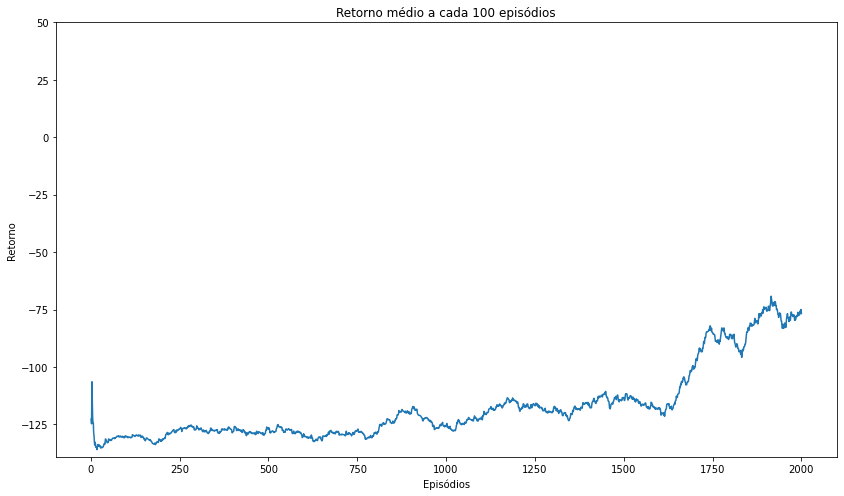

TREINANDO COM goal_x = -0.25:
- episode 50 (selected 5): loss=0.229, return_mean=-109.11, return_limit=9.67, elite=[-inf, 9.671883821487427, 9.678069204092026, 9.70483735203743, 9.712557166814804]
- episode 100 (selected 5): loss=0.266, return_mean=-124.43, return_limit=9.67, elite=[9.675801515579224, 9.681285500526428, 9.683811902999878, 9.712557166814804, 9.72097048163414]
- episode 150 (selected 5): loss=0.328, return_mean=-92.63, return_limit=9.69, elite=[9.683811902999878, 9.693853259086609, 9.694824010133743, 9.701485306024551, 9.712557166814804]
- episode 200 (selected 5): loss=0.313, return_mean=-92.57, return_limit=9.69, elite=[9.683811902999878, 9.694824010133743, 9.700721949338913, 9.70514526963234, 9.720667213201523]
- episode 250 (selected 5): loss=0.194, return_mean=-89.79, return_limit=9.69, elite=[9.689825415611267, 9.69193109869957, 9.696488678455353, 9.702968895435333, 9.703671008348465]
- episode 300 (selected 5): loss=0.160, return_mean=-80.66, return_limit=9.71, el

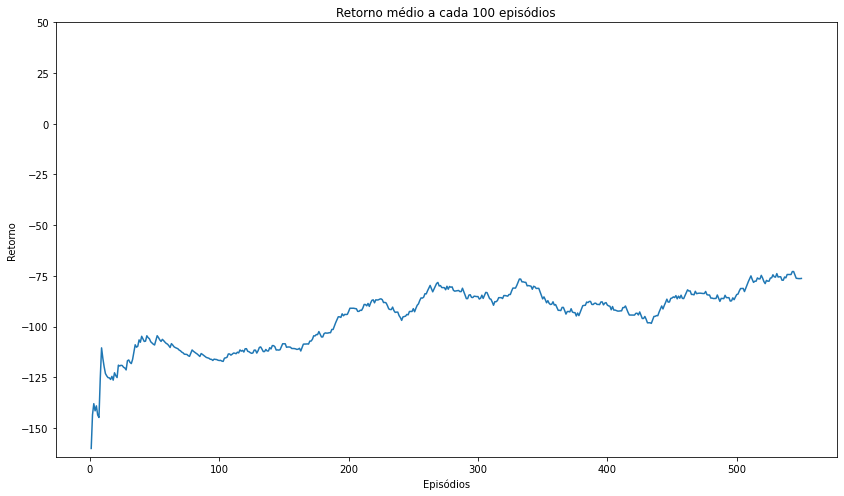

TREINANDO COM goal_x = -0.2:
- episode 50 (selected 5): loss=0.086, return_mean=-119.00, return_limit=9.61, elite=[-inf, -inf, 9.616890668869019, 9.62103596329689, 9.64295206964016]
- episode 100 (selected 5): loss=0.035, return_mean=-115.94, return_limit=9.62, elite=[-inf, 9.626910105347633, 9.633726239204407, 9.633783802390099, 9.64295206964016]
- episode 150 (selected 5): loss=0.030, return_mean=-127.53, return_limit=9.62, elite=[9.626910105347633, 9.633726239204407, 9.633783802390099, 9.634668976068497, 9.634895846247673]
- episode 200 (selected 5): loss=0.028, return_mean=-132.91, return_limit=9.62, elite=[9.626910105347633, 9.630370274186134, 9.633650198578835, 9.633783802390099, 9.634895846247673]
- episode 250 (selected 5): loss=0.009, return_mean=-126.42, return_limit=9.61, elite=[9.626910105347633, 9.630370274186134, 9.633783802390099, 9.634895846247673, 9.640011548995972]
- episode 300 (selected 5): loss=0.007, return_mean=-119.91, return_limit=9.63, elite=[9.633705869317055

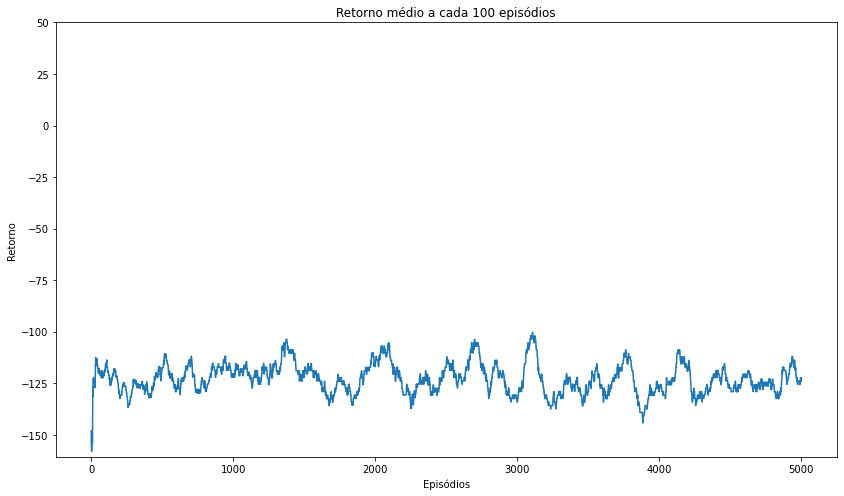

TREINANDO COM goal_x = -0.15:
- episode 50 (selected 5): loss=0.000, return_mean=-159.42, return_limit=-158.16, elite=[-inf, -inf, -158.16277360916138, -157.40723784267902, -157.40631127357483]


KeyboardInterrupt: 

In [27]:
rmax = 50.0
ENV = gym.make("MountainCar-v0")

BATCH_SIZE   = 50     # quantidade de episódios executados por época de treinamento
PROPORTION = 0.1      # percentual dos episódios (do batch) que serão selecionados

policy2 = PolicyModelCrossentropy(ENV.observation_space.shape[0], [128, 256], ENV.action_space.n, lr=0.01)

all_returns = []

curriculum_params = [(-0.30, 5000, -70.0), (-0.25, 5000, -70.0), (-0.20, 5000, -70.0), (-0.15, 5000, -80.0), (-0.10, 5000, -80.0)] #, (-0.05, 5000, -120.0), (0.00, 5000, -120.0), (0.7, 5000, -80.0)]

for goal_x, episodes, target_return in curriculum_params:
    print(f"TREINANDO COM goal_x = {goal_x}:")
    wrapped_env = SimplifiedMC(ENV, goal_x)
    
    returns, policy2 = run_crossentropy_method2(wrapped_env, episodes, BATCH_SIZE, PROPORTION, target_return=target_return, initial_policy=policy2, render=False)
    print("Últimos resultados: media =", np.mean(returns[-20:]), ", desvio padrao =", np.std(returns[-20:]))        
    plot_result(returns, rmax)
    all_returns.extend(returns)

plot_result(all_returns, rmax)



In [ ]:
# Executa alguns episódios de forma NÃO-determinística e imprime um sumário
test_policy(ENV, policy2, False, 5, render=False)